In [1]:
%cd ..

/home/tourloid/Desktop/PhD/Code/SPVD


# Dataset

In [2]:
from datasets.partnet import get_sparse_completion_dataloaders
from pclab.utils import DataLoaders

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
path = './data/PartNetProcessed/'
tr_dl, te_dl = get_sparse_completion_dataloaders(path, 'Chair')
dls = DataLoaders(tr_dl, te_dl)

# Model

In [4]:
from models.spvd import SPVUnet
from functools import partial

In [5]:
get_model = partial(SPVUnet, point_channels=4, voxel_size=0.1, num_layers=1, pres=1e-5,
                    down_blocks = [[(32, 64, 128, 192, 192, 256), 
                                    (True, True, True, True, False), 
                                    (None, None, None, 8, 8)]], 
                                    # BLOCK 1
                    up_blocks   = [[(256, 192, 192), 
                                    (True, True), 
                                    (8, 8), 
                                    (3, 3)], 
                                    # BLOCK 2
                                   [(192, 128, 64, 32), 
                                    (True, True, False), 
                                    (None, None, None), 
                                    (3, 3, 3)]])

# Training Loop

## DDPM and MaskedMSELoss

In [6]:
from pclab.learner import *
from utils.callbacks import *
from pclab.learner import Callback
from functools import partial
import torch
import torch.nn as nn

In [7]:
class DDPMCB(Callback):

    def before_batch(self, learn):
        pts = learn.batch['input']
        t = torch.tensor(learn.batch['t'])
        inp = (pts, t)
        target = learn.batch['noise'], learn.batch['mask'].view(-1)
        learn.batch = (inp, target)

class CustomMSELoss(nn.Module):

    def __init__(self):
        super().__init__()

        self.loss_fn = nn.MSELoss()
    
    def forward(self, preds, target):

        noise, mask = target

        # calculate loss only for the noisy points
        preds = preds[~mask, :3]
        
        noise = noise.view(-1, 3)[~mask]

        return self.loss_fn(preds, noise)

## LR Finder

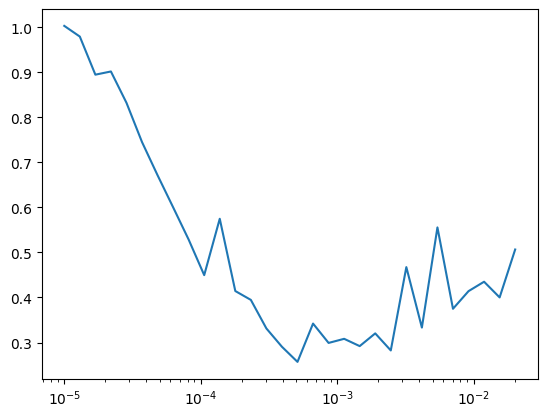

In [8]:
ddpm_cb = DDPMCB()
model = get_model()
learn = TrainLearner(model, dls, CustomMSELoss(), cbs=[ddpm_cb, DeviceCBSparse(), GradientClipCB()], opt_func=torch.optim.Adam)
learn.lr_find(max_mult=3)

## Training